In [3]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Load pickle file
with open('/Volumes/harris/volkan/fooof/fooof_results/sub-017_ses-01_recording-01_fooof.pkl', 'rb') as f:
    fg_models = pickle.load(f)

# Calculate average exponents
exps_eeg1 = fg_models['EEG1'].get_params('aperiodic_params', 'exponent')
exps_eeg2 = fg_models['EEG2'].get_params('aperiodic_params', 'exponent')
avg_exps = (exps_eeg1 + exps_eeg2) / 2

# Load and process sleep stages
df = pd.read_csv('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-017_ses-01_recording-01_time-0-98h_1Hz.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Convert to 10-second periods
df['period'] = (df.index // 10) * 10
sleep_stages_10s = df.groupby('period')['sleepStage'].agg(lambda x: pd.Series.mode(x)[0]).reset_index()

# Create 4-hour blocks
start_time = pd.to_datetime('2024-12-16 21:00:00')
block_duration = timedelta(hours=4)
blocks = []

current_time = start_time
while current_time < sleep_stages_10s['Timestamp'].max():
    end_time = current_time + block_duration
    block_data = {
        'start_time': current_time,
        'end_time': end_time,
        'props': {},
        'exponents': {}
    }
    
    # Get data for this block
    mask = (sleep_stages_10s['Timestamp'] >= current_time) & (sleep_stages_10s['Timestamp'] < end_time)
    block_stages = sleep_stages_10s[mask]
    
    # Calculate proportions and mean exponents for each stage
    for stage in [1, 2, 3]:  # Awake, NREM, REM
        stage_mask = block_stages['sleepStage'] == stage
        block_data['props'][stage] = stage_mask.mean()
        block_data['exponents'][stage] = avg_exps[mask & stage_mask].mean()
    
    blocks.append(block_data)
    current_time = end_time

# Separate into light/dark cycles
light_blocks = [b for b in blocks if 9 <= b['start_time'].hour < 21]
dark_blocks = [b for b in blocks if b['start_time'].hour >= 21 or b['start_time'].hour < 9]

# Create plots
stages = {1: 'Awake', 2: 'NREM', 3: 'REM'}
periods = {'Light': light_blocks, 'Dark': dark_blocks}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, (period, blocks) in enumerate(periods.items()):
    for j, (stage_num, stage_name) in enumerate(stages.items()):
        props = [b['props'][stage_num] for b in blocks]
        exps = [b['exponents'][stage_num] for b in blocks]
        
        ax = axes[i, j]
        ax.scatter(props, exps)
        ax.set_title(f'{period} - {stage_name}')
        ax.set_xlabel('Proportion')
        ax.set_ylabel('Average Exponent')

plt.tight_layout()
#plt.savefig('sleep_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

KeyError: 'Timestamp'

/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_6255/2254844617.py:17: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(


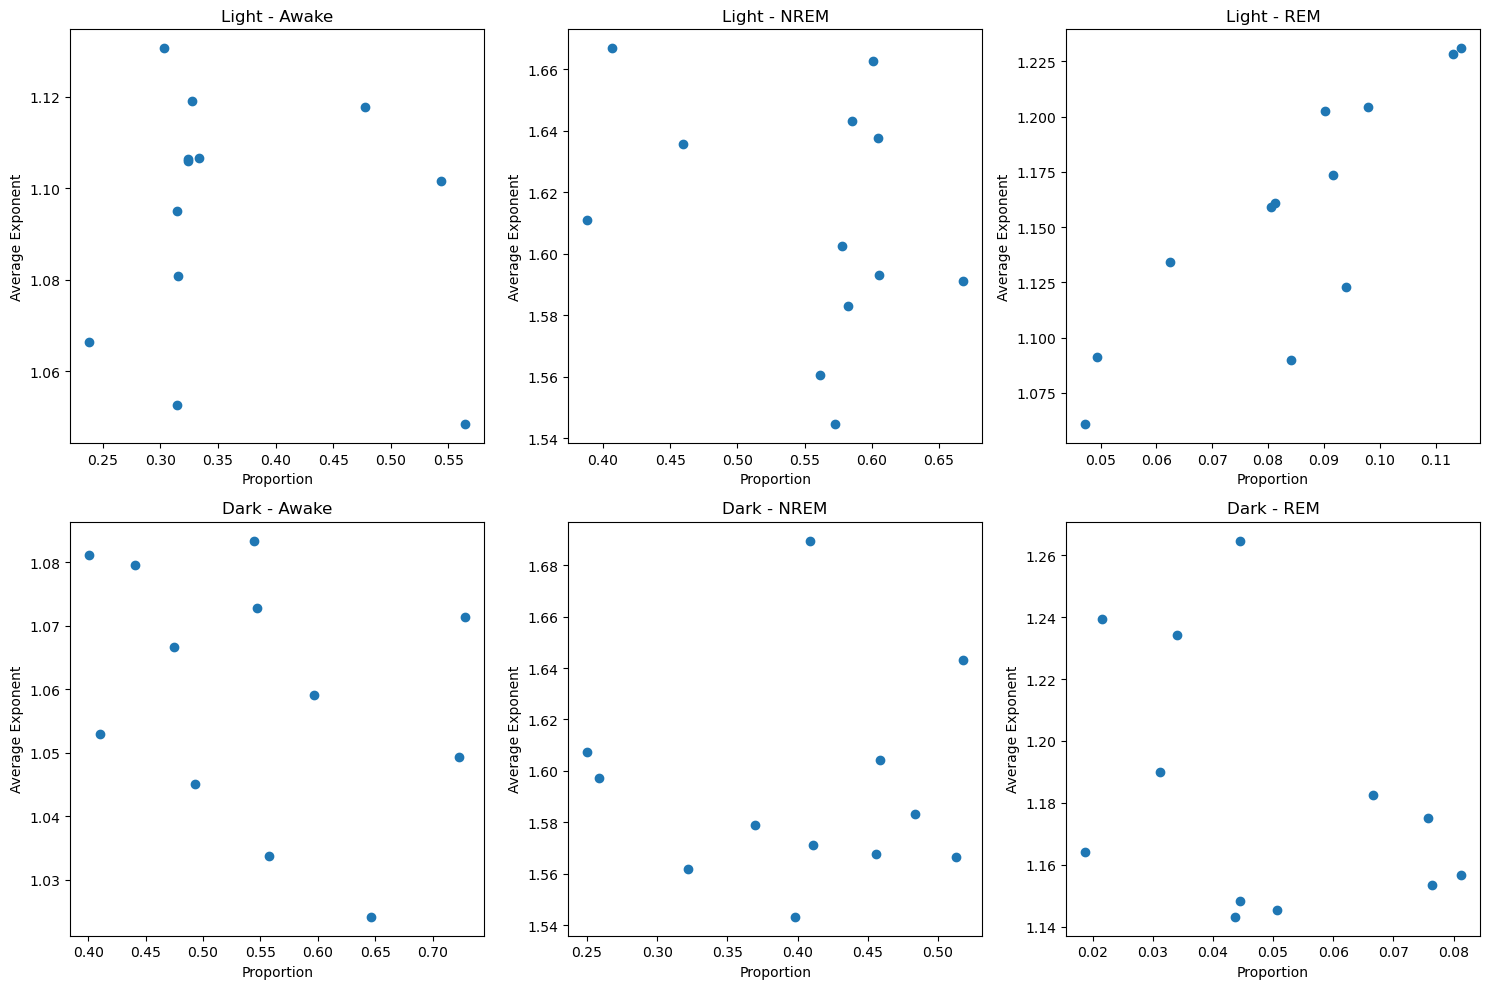

In [4]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
with open('/Volumes/harris/volkan/fooof/fooof_results/sub-017_ses-01_recording-01_fooof.pkl', 'rb') as f:
    fg_models = pickle.load(f)

# Calculate average exponents and create timestamps
exps_eeg1 = fg_models['EEG1'].get_params('aperiodic_params', 'exponent')
exps_eeg2 = fg_models['EEG2'].get_params('aperiodic_params', 'exponent')
avg_exps = (exps_eeg1 + exps_eeg2) / 2

timestamps = pd.date_range(
    start=pd.to_datetime('2024-12-16 17:50:47'),  # Original start time
    periods=len(avg_exps),
    freq='10S'
)

# Create exponents DataFrame
exp_df = pd.DataFrame({
    'Timestamp': timestamps,
    'Exponent': avg_exps
})

# Process sleep stages
df = pd.read_csv('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-017_ses-01_recording-01_time-0-98h_1Hz.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['period'] = (df.index // 10) * 10
sleep_stages_10s = df.groupby('period').agg({
    'Timestamp': 'first',
    'sleepStage': lambda x: pd.Series.mode(x)[0]
}).reset_index()

# Find start time index and align data
start_time = pd.to_datetime('2024-12-16 21:00:00')
exp_df = exp_df[exp_df['Timestamp'] >= start_time].reset_index(drop=True)
sleep_stages_10s = sleep_stages_10s[sleep_stages_10s['Timestamp'] >= start_time].reset_index(drop=True)

# Process blocks
blocks = []
current_time = start_time
block_duration = timedelta(hours=4)

while current_time < sleep_stages_10s['Timestamp'].max():
    end_time = current_time + block_duration
    mask = (exp_df['Timestamp'] >= current_time) & (exp_df['Timestamp'] < end_time)
    
    block_data = {
        'start_time': current_time,
        'end_time': end_time,
        'props': {},
        'exponents': {}
    }
    
    for stage in [1, 2, 3]:
        stage_mask = sleep_stages_10s.loc[mask, 'sleepStage'] == stage
        block_data['props'][stage] = stage_mask.mean()
        block_data['exponents'][stage] = exp_df.loc[mask & stage_mask, 'Exponent'].mean()
    
    blocks.append(block_data)
    current_time = end_time

# Separate cycles and plot
light_blocks = [b for b in blocks if 9 <= b['start_time'].hour < 21]
dark_blocks = [b for b in blocks if b['start_time'].hour >= 21 or b['start_time'].hour < 9]

stages = {1: 'Awake', 2: 'NREM', 3: 'REM'}
periods = {'Light': light_blocks, 'Dark': dark_blocks}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, (period, blocks) in enumerate(periods.items()):
    for j, (stage_num, stage_name) in enumerate(stages.items()):
        props = [b['props'][stage_num] for b in blocks]
        exps = [b['exponents'][stage_num] for b in blocks]
        
        ax = axes[i, j]
        ax.scatter(props, exps)
        ax.set_title(f'{period} - {stage_name}')
        ax.set_xlabel('Proportion')
        ax.set_ylabel('Average Exponent')

plt.tight_layout()
plt.show()

/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_6255/1505920999.py:53: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_6255/1505920999.py:53: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_6255/1505920999.py:53: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_6255/1505920999.py:53: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_6255/1505920999.py:53: FutureWarning: 'S' is deprecated and will be removed in a future version, plea

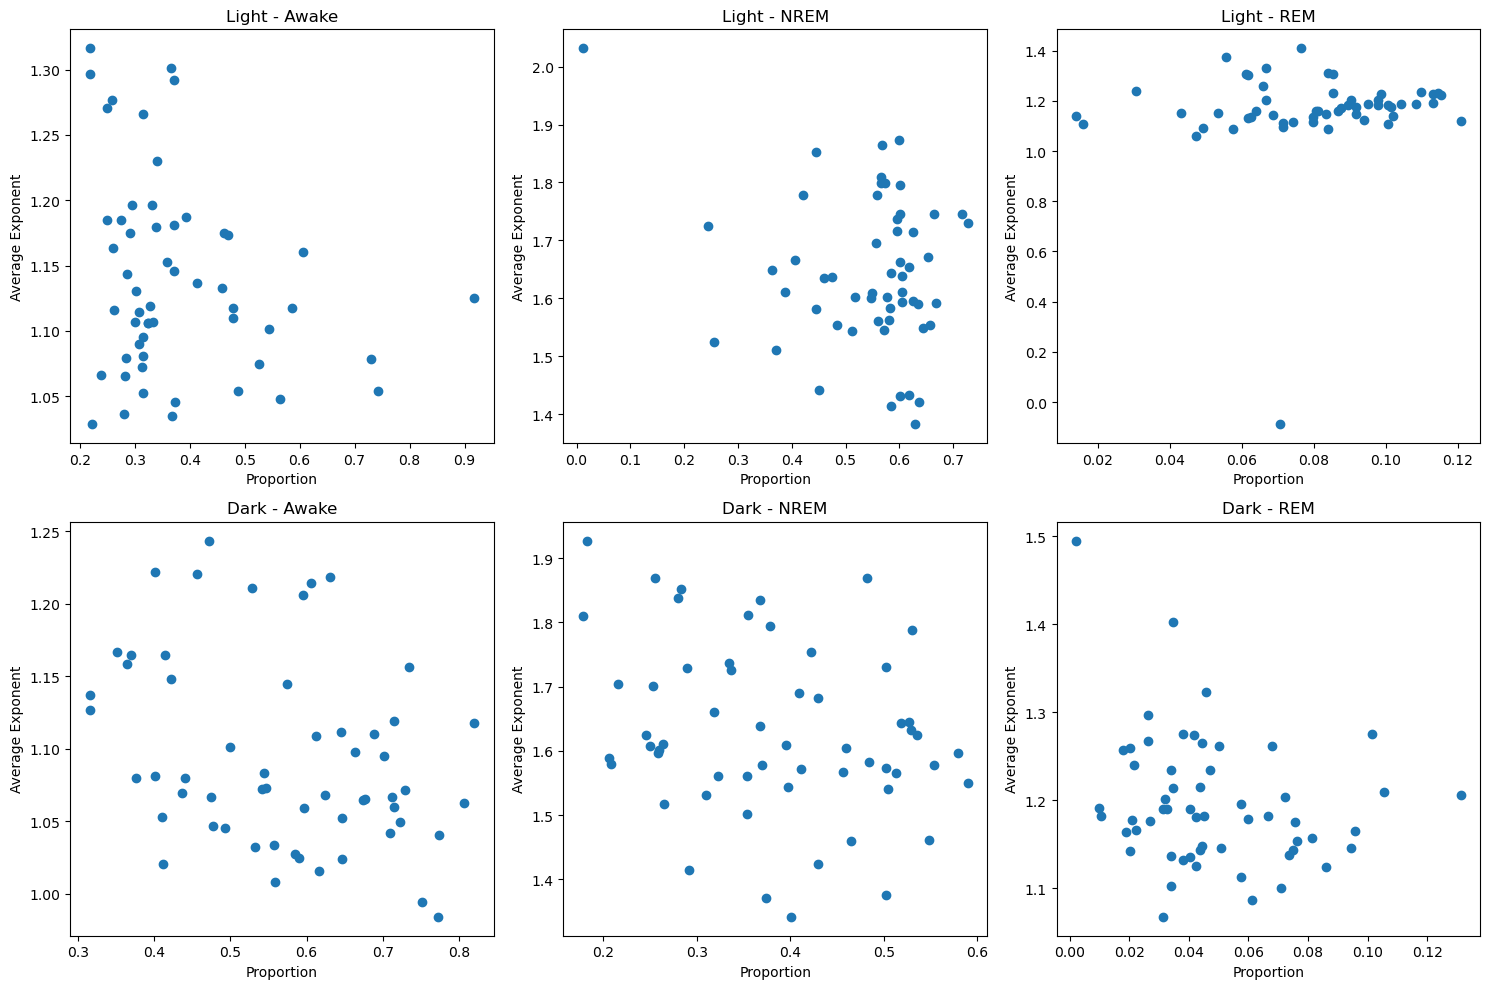

In [7]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Data configuration
pickle_files = [
    '/Volumes/harris/volkan/fooof/fooof_results/sub-007_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-010_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-011_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-015_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-016_ses-02_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-017_ses-01_recording-01_fooof.pkl'
]

csv_files = [
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-007_ses-01_recording-01_time-0-70.5h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-010_ses-01_recording-01_time-0-69h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-011_ses-01_recording-01_time-0-72h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-015_ses-01_recording-01_time-0-49h_1Hz_stitched.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-016_ses-02_recording-01_time-0-91h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-017_ses-01_recording-01_time-0-98h_1Hz.csv'
]

start_times = ['2024-07-02 15:13:12', '2024-09-16 16:01:50','2024-09-25 15:07:30','2024-11-18 12:35:00','2024-11-29 13:29:14','2024-12-16 17:50:47']

block_start_times = ['2024-07-02 17:00:00', '2024-09-16 17:00:00', '2024-09-25 17:00:00', '2024-11-18 17:00:00', '2024-11-29 17:00:00', '2024-12-16 21:00:00']

exclusion_ranges = {
    '015': [('2024-11-19 08:49:50', '2024-11-19 08:57:59')]
}

# Initialize storage
all_blocks = []

# Process each subject
for pickle_file, csv_file, start_time, block_start in zip(pickle_files, csv_files, start_times, block_start_times):
    # Extract subject ID
    subject_id = pickle_file.split('sub-')[1][:3]
    
    # Load FOOOF results
    with open(pickle_file, 'rb') as f:
        fg_models = pickle.load(f)
    
    # Calculate average exponents and create timestamps
    exps_eeg1 = fg_models['EEG1'].get_params('aperiodic_params', 'exponent')
    exps_eeg2 = fg_models['EEG2'].get_params('aperiodic_params', 'exponent')
    avg_exps = (exps_eeg1 + exps_eeg2) / 2
    
    timestamps = pd.date_range(
        start=pd.to_datetime(start_time),
        periods=len(avg_exps),
        freq='10S'
    )
    
    # Create exponents DataFrame
    exp_df = pd.DataFrame({
        'Timestamp': timestamps,
        'Exponent': avg_exps
    })
    
    # Process sleep stages
    df = pd.read_csv(csv_file)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['period'] = (df.index // 10) * 10
    sleep_stages_10s = df.groupby('period').agg({
        'Timestamp': 'first',
        'sleepStage': lambda x: pd.Series.mode(x)[0]
    }).reset_index()
    
    # Apply exclusions if any
    if subject_id in exclusion_ranges:
        for start_exc, end_exc in exclusion_ranges[subject_id]:
            mask = ~((sleep_stages_10s['Timestamp'] >= pd.to_datetime(start_exc)) & 
                    (sleep_stages_10s['Timestamp'] <= pd.to_datetime(end_exc)))
            sleep_stages_10s = sleep_stages_10s[mask]
    
    # Align data to block start time
    block_start_dt = pd.to_datetime(block_start)
    exp_df = exp_df[exp_df['Timestamp'] >= block_start_dt].reset_index(drop=True)
    sleep_stages_10s = sleep_stages_10s[sleep_stages_10s['Timestamp'] >= block_start_dt].reset_index(drop=True)
    
    # Process blocks
    current_time = block_start_dt
    block_duration = timedelta(hours=4)
    
    while current_time < sleep_stages_10s['Timestamp'].max():
        end_time = current_time + block_duration
        mask = (exp_df['Timestamp'] >= current_time) & (exp_df['Timestamp'] < end_time)
        
        block_data = {
            'subject': subject_id,
            'start_time': current_time,
            'end_time': end_time,
            'props': {},
            'exponents': {}
        }
        
        for stage in [1, 2, 3]:
            stage_mask = sleep_stages_10s.loc[mask, 'sleepStage'] == stage
            block_data['props'][stage] = stage_mask.mean()
            block_data['exponents'][stage] = exp_df.loc[mask & stage_mask, 'Exponent'].mean()
        
        all_blocks.append(block_data)
        current_time = end_time

# Create plots
stages = {1: 'Awake', 2: 'NREM', 3: 'REM'}
light_blocks = [b for b in all_blocks if 9 <= b['start_time'].hour < 21]
dark_blocks = [b for b in all_blocks if b['start_time'].hour >= 21 or b['start_time'].hour < 9]
periods = {'Light': light_blocks, 'Dark': dark_blocks}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, (period, blocks) in enumerate(periods.items()):
    for j, (stage_num, stage_name) in enumerate(stages.items()):
        props = [b['props'][stage_num] for b in blocks]
        exps = [b['exponents'][stage_num] for b in blocks]
        
        ax = axes[i, j]
        ax.scatter(props, exps)
        ax.set_title(f'{period} - {stage_name}')
        ax.set_xlabel('Proportion')
        ax.set_ylabel('Average Exponent')

plt.tight_layout()
plt.show()

/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_6255/1068075737.py:53: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_6255/1068075737.py:53: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_6255/1068075737.py:53: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_6255/1068075737.py:53: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_6255/1068075737.py:53: FutureWarning: 'S' is deprecated and will be removed in a future version, plea

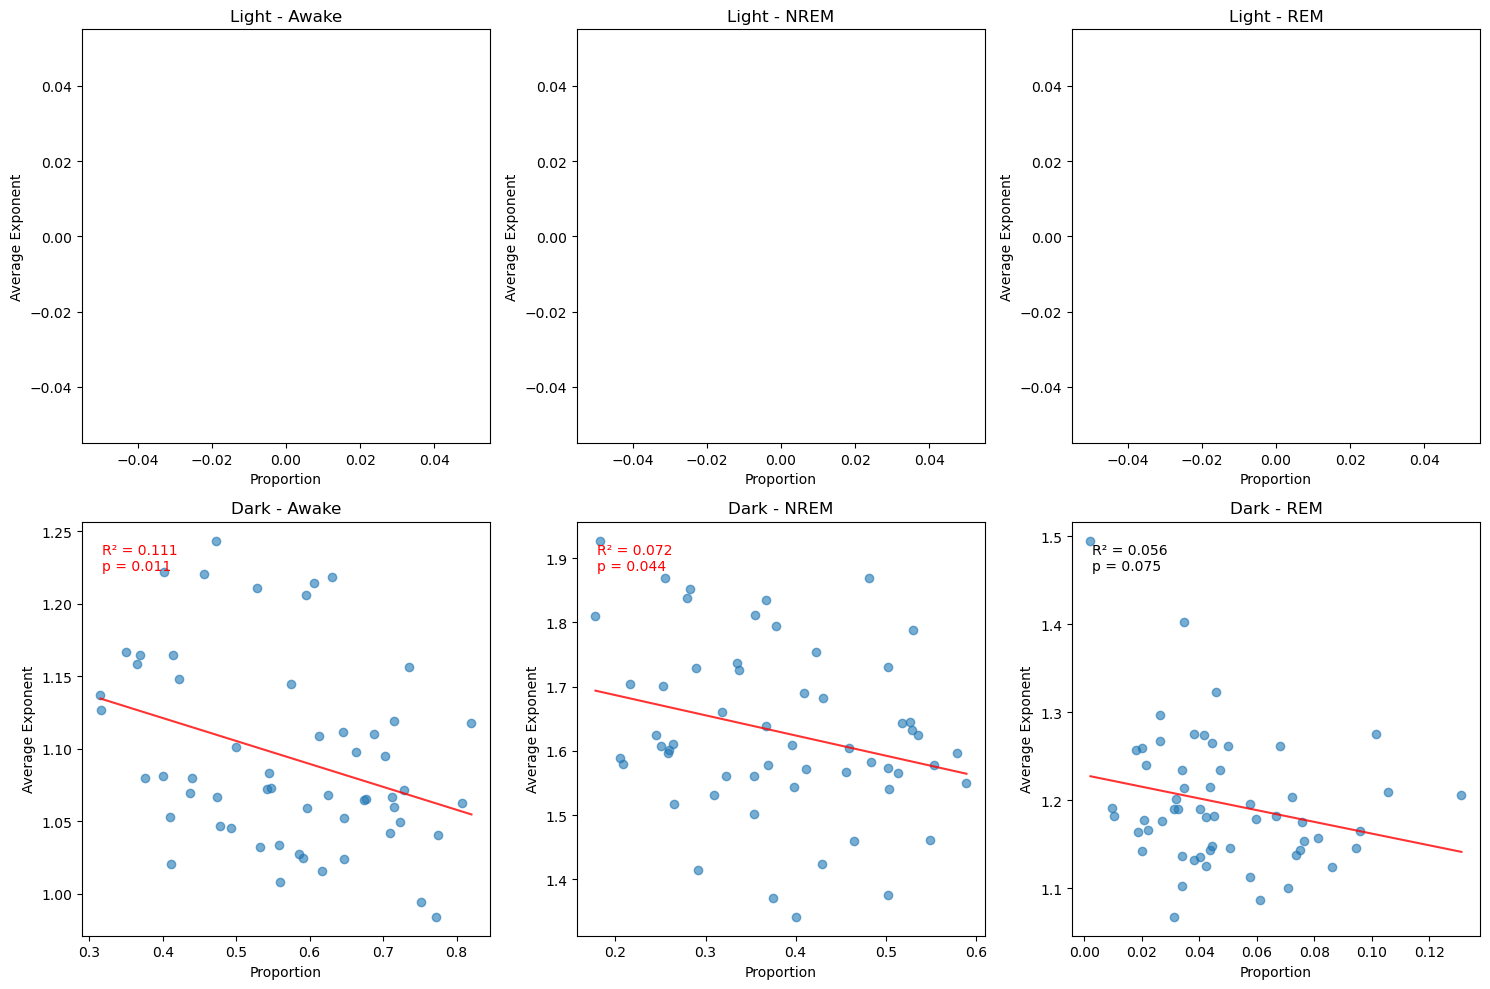

In [13]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Data configuration
pickle_files = [
    '/Volumes/harris/volkan/fooof/fooof_results/sub-007_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-010_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-011_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-015_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-016_ses-02_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-017_ses-01_recording-01_fooof.pkl'
]

csv_files = [
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-007_ses-01_recording-01_time-0-70.5h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-010_ses-01_recording-01_time-0-69h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-011_ses-01_recording-01_time-0-72h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-015_ses-01_recording-01_time-0-49h_1Hz_stitched.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-016_ses-02_recording-01_time-0-91h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-017_ses-01_recording-01_time-0-98h_1Hz.csv'
]

start_times = ['2024-07-02 15:13:12', '2024-09-16 16:01:50','2024-09-25 15:07:30','2024-11-18 12:35:00','2024-11-29 13:29:14','2024-12-16 17:50:47']

block_start_times = ['2024-07-02 17:00:00', '2024-09-16 17:00:00', '2024-09-25 17:00:00', '2024-11-18 17:00:00', '2024-11-29 17:00:00', '2024-12-16 21:00:00']

exclusion_ranges = {
    '015': [('2024-11-19 08:49:50', '2024-11-19 08:57:59')]
}

# Initialize storage
all_blocks = []

# Process each subject
for pickle_file, csv_file, start_time, block_start in zip(pickle_files, csv_files, start_times, block_start_times):
    # Extract subject ID
    subject_id = pickle_file.split('sub-')[1][:3]
    
    # Load FOOOF results
    with open(pickle_file, 'rb') as f:
        fg_models = pickle.load(f)
    
    # Calculate average exponents and create timestamps
    exps_eeg1 = fg_models['EEG1'].get_params('aperiodic_params', 'exponent')
    exps_eeg2 = fg_models['EEG2'].get_params('aperiodic_params', 'exponent')
    avg_exps = (exps_eeg1 + exps_eeg2) / 2
    
    timestamps = pd.date_range(
        start=pd.to_datetime(start_time),
        periods=len(avg_exps),
        freq='10S'
    )
    
    # Create exponents DataFrame
    exp_df = pd.DataFrame({
        'Timestamp': timestamps,
        'Exponent': avg_exps
    })
    
    # Process sleep stages
    df = pd.read_csv(csv_file)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['period'] = (df.index // 10) * 10
    sleep_stages_10s = df.groupby('period').agg({
        'Timestamp': 'first',
        'sleepStage': lambda x: pd.Series.mode(x)[0]
    }).reset_index()
    
    # Apply exclusions if any
    if subject_id in exclusion_ranges:
        for start_exc, end_exc in exclusion_ranges[subject_id]:
            mask = ~((sleep_stages_10s['Timestamp'] >= pd.to_datetime(start_exc)) & 
                    (sleep_stages_10s['Timestamp'] <= pd.to_datetime(end_exc)))
            sleep_stages_10s = sleep_stages_10s[mask]
    
    # Align data to block start time
    block_start_dt = pd.to_datetime(block_start)
    exp_df = exp_df[exp_df['Timestamp'] >= block_start_dt].reset_index(drop=True)
    sleep_stages_10s = sleep_stages_10s[sleep_stages_10s['Timestamp'] >= block_start_dt].reset_index(drop=True)
    
    # Process blocks
    current_time = block_start_dt
    block_duration = timedelta(hours=4)
    
    while current_time < sleep_stages_10s['Timestamp'].max():
        end_time = current_time + block_duration
        mask = (exp_df['Timestamp'] >= current_time) & (exp_df['Timestamp'] < end_time)
        
        block_data = {
            'subject': subject_id,
            'start_time': current_time,
            'end_time': end_time,
            'props': {},
            'exponents': {}
        }
        
        for stage in [1, 2, 3]:
            stage_mask = sleep_stages_10s.loc[mask, 'sleepStage'] == stage
            block_data['props'][stage] = stage_mask.mean()
            block_data['exponents'][stage] = exp_df.loc[mask & stage_mask, 'Exponent'].mean()
        
        all_blocks.append(block_data)
        current_time = end_time

# Convert blocks to DataFrame format
df_blocks = pd.DataFrame([
    {
        'period': 'Light' if 9 <= b['start_time'].hour < 21 else 'Dark',
        'stage_1_prop': b['props'][1],
        'stage_2_prop': b['props'][2],
        'stage_3_prop': b['props'][3],
        'stage_1_exp': b['exponents'][1],
        'stage_2_exp': b['exponents'][2],
        'stage_3_exp': b['exponents'][3]
    }
    for b in blocks
])

# Create plots with regression lines
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
stages = {1: 'Awake', 2: 'NREM', 3: 'REM'}
periods = ['Light', 'Dark']

for i, period in enumerate(periods):
    period_data = df_blocks[df_blocks['period'] == period]
    
    for j, (stage_num, stage_name) in enumerate(stages.items()):
        ax = axes[i, j]
        x = period_data[f'stage_{stage_num}_prop']
        y = period_data[f'stage_{stage_num}_exp']
        
        # Plot scatter
        ax.scatter(x, y, alpha=0.6)
        
        # Run regression
        mask = ~np.isnan(x) & ~np.isnan(y)
        if len(x[mask]) > 1:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
            
            # Plot regression line
            x_range = np.linspace(x.min(), x.max(), 100)
            y_pred = slope * x_range + intercept
            ax.plot(x_range, y_pred, 'r-', alpha=0.8)
            
            # Add stats annotation
            ax.text(0.05, 0.95, 
                   f'R² = {r_value**2:.3f}\np = {p_value:.3f}',
                   transform=ax.transAxes,
                   verticalalignment='top',
                   color='red' if p_value < 0.05 else 'black')
        
        ax.set_title(f'{period} - {stage_name}')
        ax.set_xlabel('Proportion')
        ax.set_ylabel('Average Exponent')

plt.tight_layout()
#plt.savefig('/Volumes/harris/volkan/fooof/plots/sleep_stage_regression.png', dpi=600, bbox_inches='tight')
plt.show()


Data Summary:
period
Dark     57
Light    55
dtype: int64


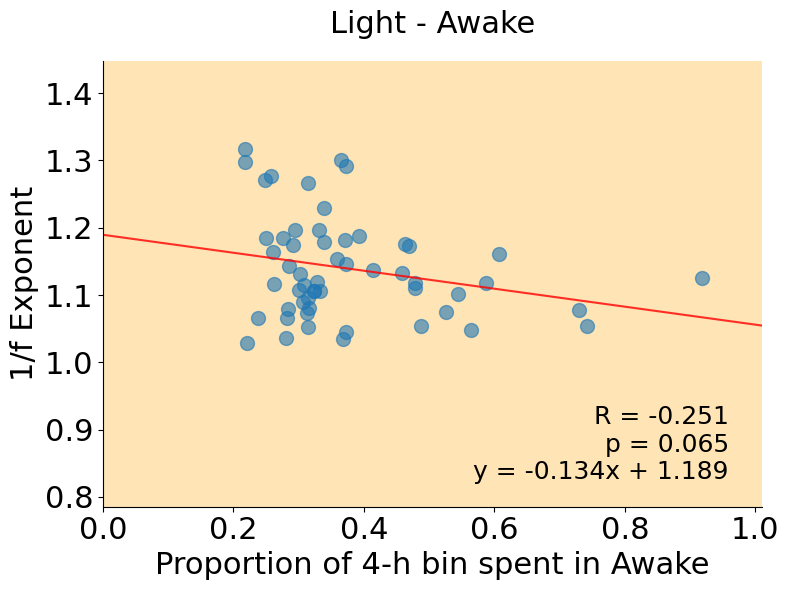

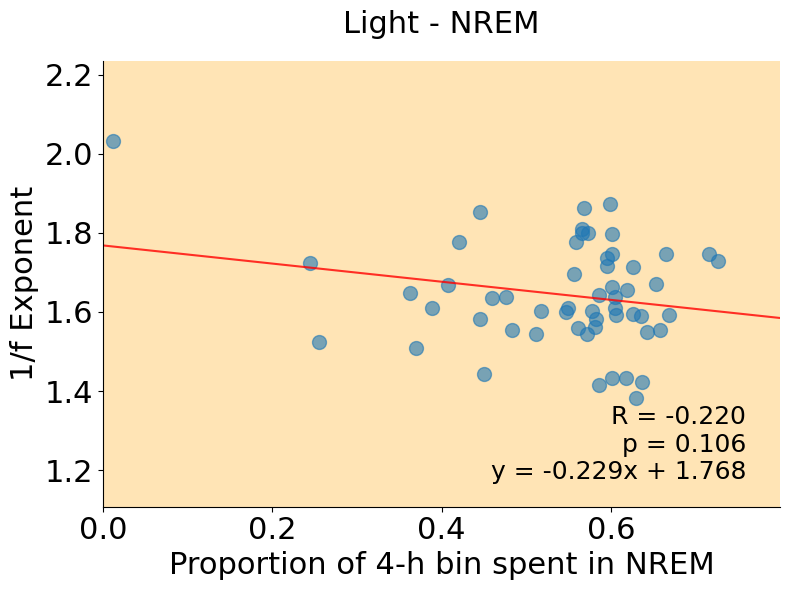

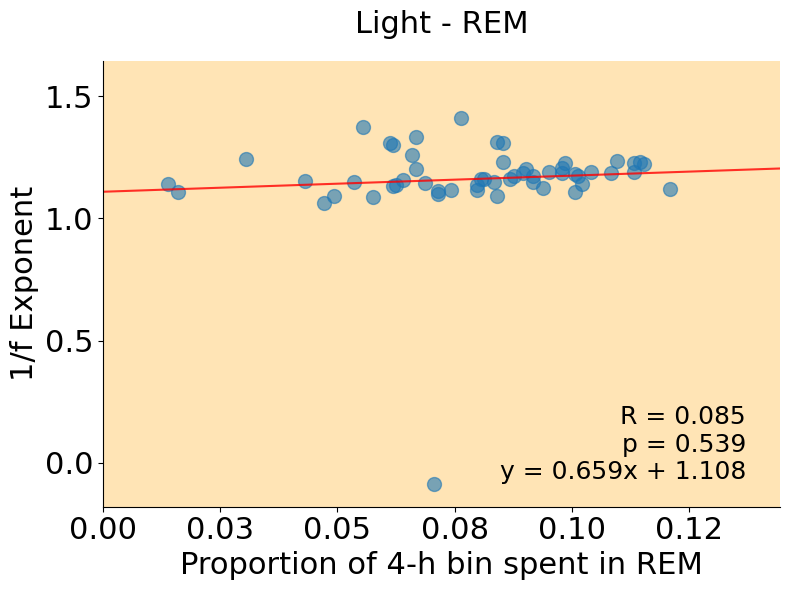

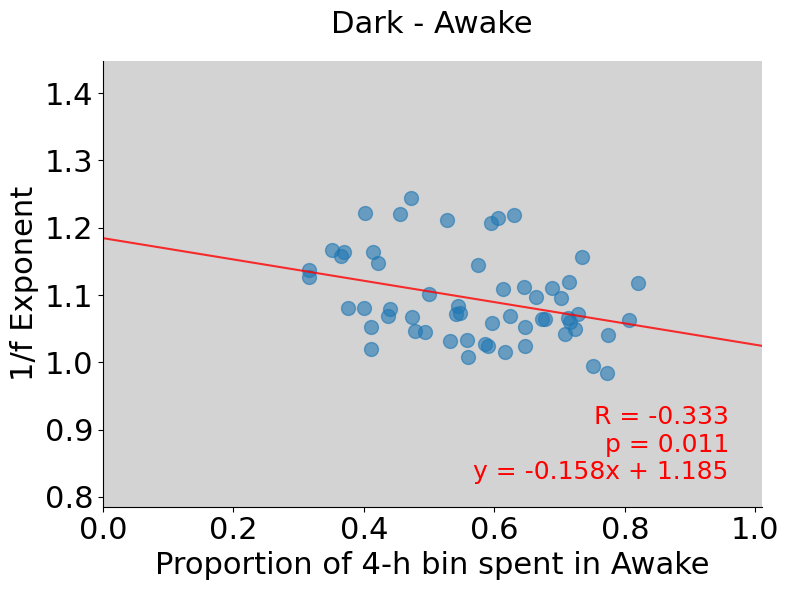

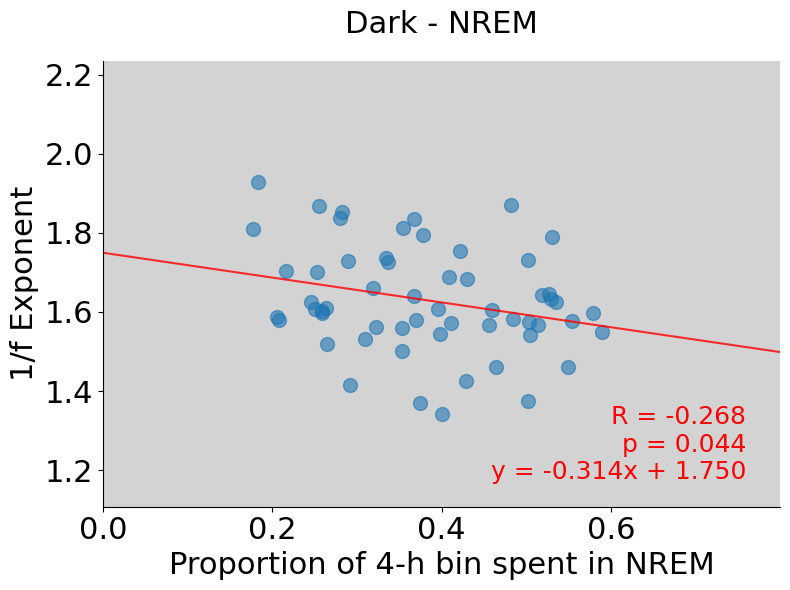

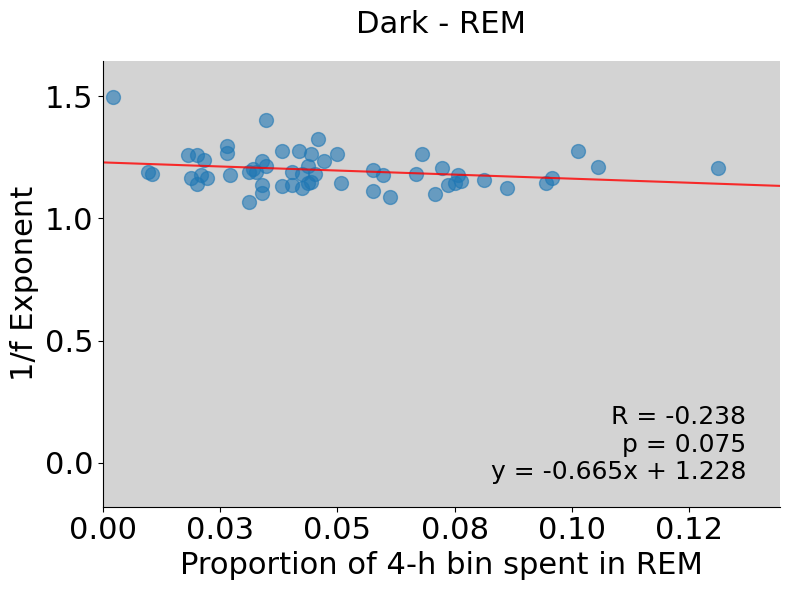

In [39]:
# Convert blocks to DataFrame format with explicit period classification
all_data = []
for b in all_blocks:
    hour = b['start_time'].hour
    period = 'Light' if 9 <= hour < 21 else 'Dark'
    
    row_data = {
        'period': period,
        'start_time': b['start_time'],
        'subject': b['subject']
    }
    
    # Add proportions and exponents
    for stage in [1, 2, 3]:
        row_data[f'stage_{stage}_prop'] = float(b['props'][stage])
        row_data[f'stage_{stage}_exp'] = float(b['exponents'][stage])
    
    all_data.append(row_data)

df_blocks = pd.DataFrame(all_data)

# Verify data distribution
print("\nData Summary:")
print(df_blocks.groupby('period').size())

# Calculate stage-specific limits
stage_limits = {}
for stage_num in [1, 2, 3]:
    props = df_blocks[f'stage_{stage_num}_prop']
    exps = df_blocks[f'stage_{stage_num}_exp']
    stage_limits[stage_num] = {
        'x': (0, props.max() * 1.1),
        'y': (exps.min() * 0.9 - 0.1, exps.max() * 1.1)
    }

# Modified plotting code
stages = {1: 'Awake', 2: 'NREM', 3: 'REM'}
periods = ['Light', 'Dark']
colors = {'Light': 'moccasin', 'Dark': 'lightgray'}

# Create individual plots
for period in periods:
    period_data = df_blocks[df_blocks['period'] == period]
    
    for stage_num, stage_name in stages.items():
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111)
        
        # Set background color
        ax.set_facecolor(colors[period])
        
        x = period_data[f'stage_{stage_num}_prop']
        y = period_data[f'stage_{stage_num}_exp']
        
        # Plot scatter
        ax.scatter(x, y, alpha=0.6, s=100)
        
        # Run regression
        mask = ~np.isnan(x) & ~np.isnan(y)
        if len(x[mask]) > 1:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
            
            x_range = np.linspace(stage_limits[stage_num]['x'][0], 
                                stage_limits[stage_num]['x'][1], 100)
            y_pred = slope * x_range + intercept
            ax.plot(x_range, y_pred, 'r-', alpha=0.8)
            
            eq_text = f'y = {slope:.3f}x + {intercept:.3f}'
            stats_text = f'R = {r_value:.3f}\np = {p_value:.3f}\n{eq_text}'
            ax.text(0.95, 0.05, stats_text,
                   transform=ax.transAxes,
                   verticalalignment='bottom',
                   horizontalalignment='right',
                   color='red' if p_value < 0.05 else 'black', fontsize=18)
        
        # Set consistent axis limits
        ax.set_xlim(stage_limits[stage_num]['x'])
        ax.set_ylim(stage_limits[stage_num]['y'])

        # Format x-axis ticks for REM stage only
        if stage_num == 3:  # REM stage
            ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

        # Remove spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.set_title(f'{period} - {stage_name}', fontsize=22, pad=20)
        ax.set_xlabel(f'Proportion of 4-h bin spent in {stage_name}', fontsize=22)
        ax.set_ylabel('1/f Exponent', fontsize=22)
        ax.tick_params(axis='both', labelsize=22)
        
        plt.tight_layout()
        #plt.savefig(f'/Volumes/harris/volkan/fooof/plots/sleep_stage_regression_{period}_{stage_name}.png', dpi=600, bbox_inches='tight')
        plt.show()

/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_6255/3605626085.py:53: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_6255/3605626085.py:53: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_6255/3605626085.py:53: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_6255/3605626085.py:53: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_6255/3605626085.py:53: FutureWarning: 'S' is deprecated and will be removed in a future version, plea


Data Summary:
period
Dark     57
Light    55
dtype: int64


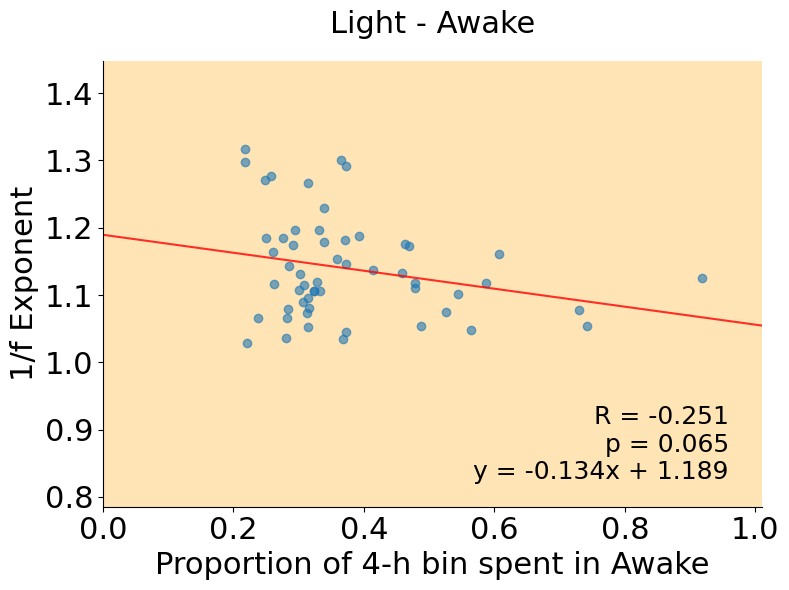

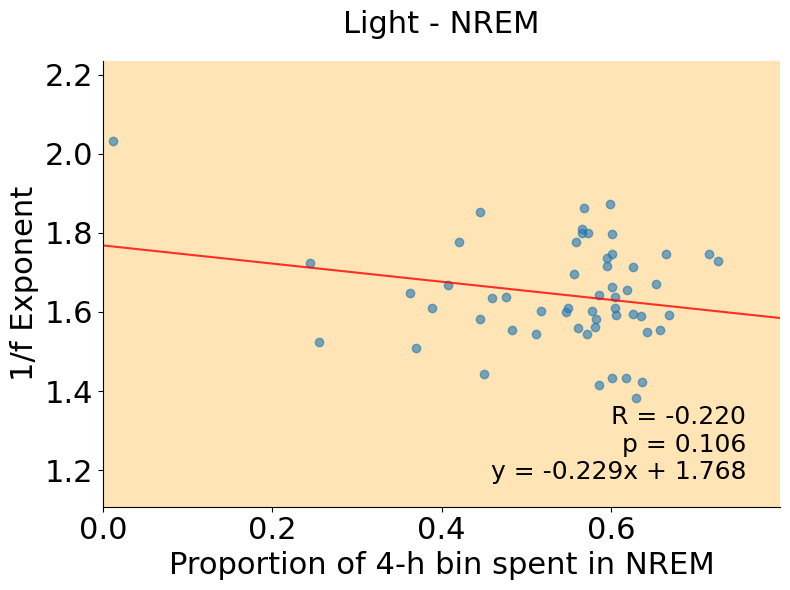

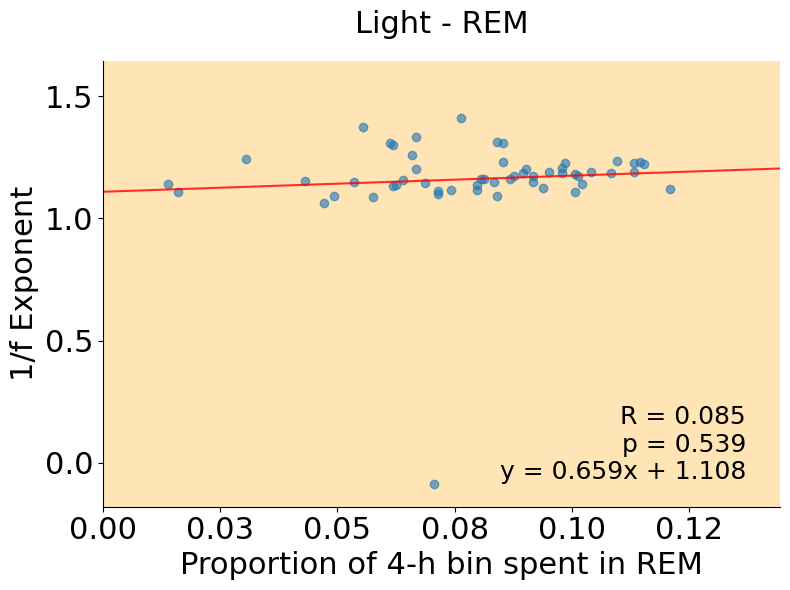

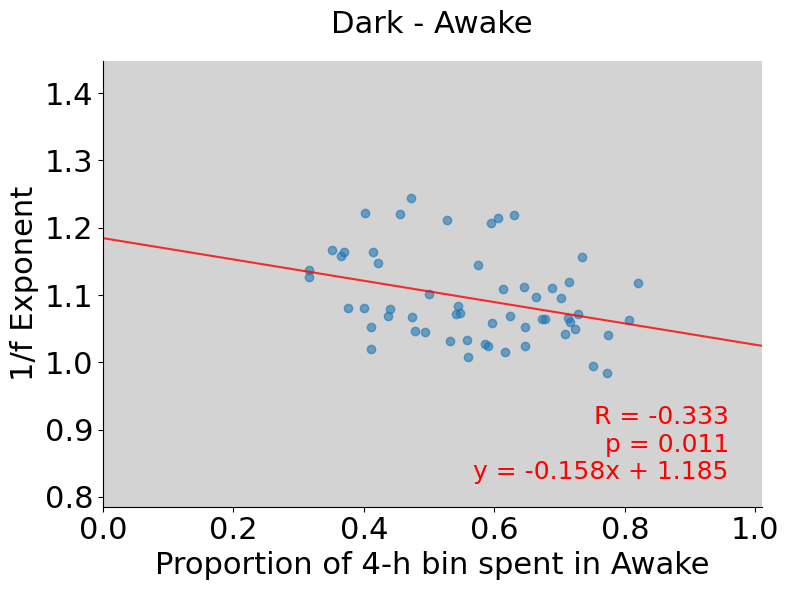

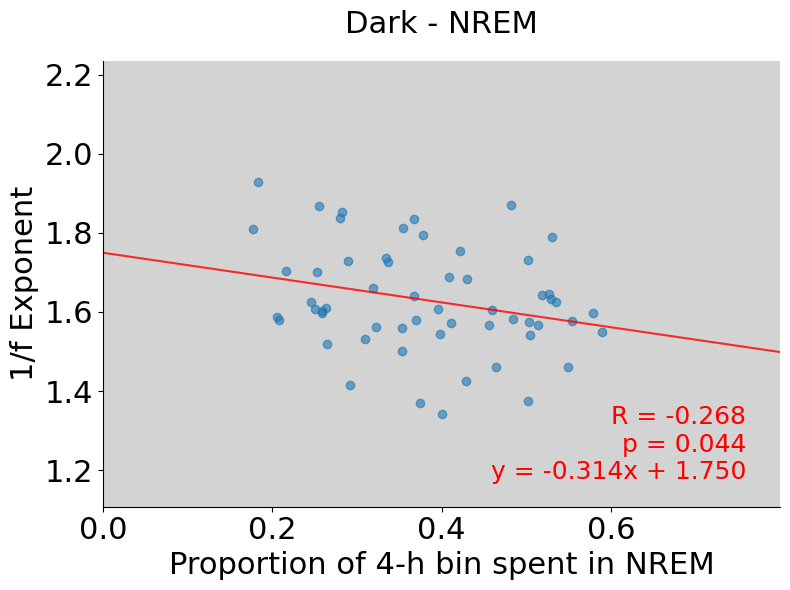

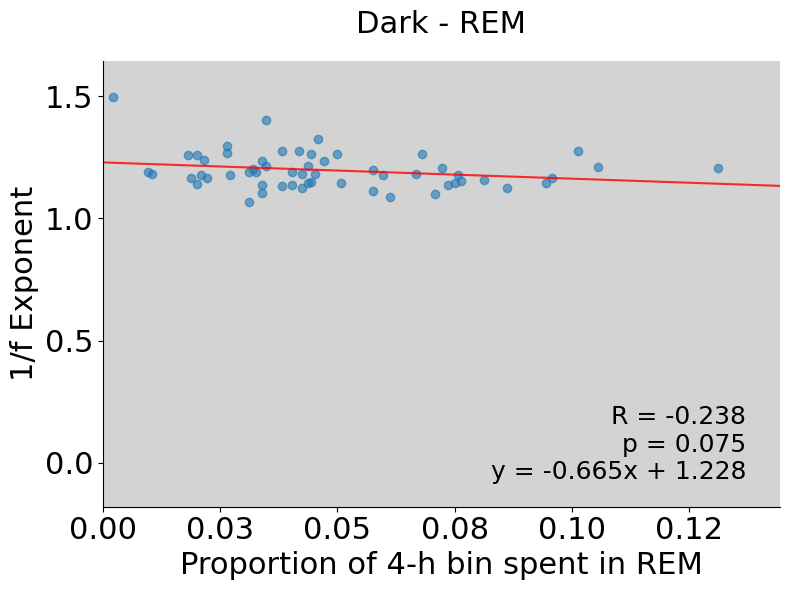

In [37]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Data configuration
pickle_files = [
    '/Volumes/harris/volkan/fooof/fooof_results/sub-007_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-010_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-011_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-015_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-016_ses-02_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-017_ses-01_recording-01_fooof.pkl'
]

csv_files = [
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-007_ses-01_recording-01_time-0-70.5h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-010_ses-01_recording-01_time-0-69h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-011_ses-01_recording-01_time-0-72h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-015_ses-01_recording-01_time-0-49h_1Hz_stitched.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-016_ses-02_recording-01_time-0-91h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-017_ses-01_recording-01_time-0-98h_1Hz.csv'
]

start_times = ['2024-07-02 15:13:12', '2024-09-16 16:01:50','2024-09-25 15:07:30','2024-11-18 12:35:00','2024-11-29 13:29:14','2024-12-16 17:50:47']

block_start_times = ['2024-07-02 17:00:00', '2024-09-16 17:00:00', '2024-09-25 17:00:00', '2024-11-18 17:00:00', '2024-11-29 17:00:00', '2024-12-16 21:00:00']

exclusion_ranges = {
    '015': [('2024-11-19 08:49:50', '2024-11-19 08:57:59')]
}

# Initialize storage
all_blocks = []

# Process each subject
for pickle_file, csv_file, start_time, block_start in zip(pickle_files, csv_files, start_times, block_start_times):
    # Extract subject ID
    subject_id = pickle_file.split('sub-')[1][:3]
    
    # Load FOOOF results
    with open(pickle_file, 'rb') as f:
        fg_models = pickle.load(f)
    
    # Calculate average exponents and create timestamps
    exps_eeg1 = fg_models['EEG1'].get_params('aperiodic_params', 'exponent')
    exps_eeg2 = fg_models['EEG2'].get_params('aperiodic_params', 'exponent')
    avg_exps = (exps_eeg1 + exps_eeg2) / 2
    
    timestamps = pd.date_range(
        start=pd.to_datetime(start_time),
        periods=len(avg_exps),
        freq='10S'
    )
    
    # Create exponents DataFrame
    exp_df = pd.DataFrame({
        'Timestamp': timestamps,
        'Exponent': avg_exps
    })
    
    # Process sleep stages
    df = pd.read_csv(csv_file)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['period'] = (df.index // 10) * 10
    sleep_stages_10s = df.groupby('period').agg({
        'Timestamp': 'first',
        'sleepStage': lambda x: pd.Series.mode(x)[0]
    }).reset_index()
    
    # Apply exclusions if any
    if subject_id in exclusion_ranges:
        for start_exc, end_exc in exclusion_ranges[subject_id]:
            mask = ~((sleep_stages_10s['Timestamp'] >= pd.to_datetime(start_exc)) & 
                    (sleep_stages_10s['Timestamp'] <= pd.to_datetime(end_exc)))
            sleep_stages_10s = sleep_stages_10s[mask]
    
    # Align data to block start time
    block_start_dt = pd.to_datetime(block_start)
    exp_df = exp_df[exp_df['Timestamp'] >= block_start_dt].reset_index(drop=True)
    sleep_stages_10s = sleep_stages_10s[sleep_stages_10s['Timestamp'] >= block_start_dt].reset_index(drop=True)
    
    # Process blocks
    current_time = block_start_dt
    block_duration = timedelta(hours=4)
    
    while current_time < sleep_stages_10s['Timestamp'].max():
        end_time = current_time + block_duration
        mask = (exp_df['Timestamp'] >= current_time) & (exp_df['Timestamp'] < end_time)
        
        block_data = {
            'subject': subject_id,
            'start_time': current_time,
            'end_time': end_time,
            'props': {},
            'exponents': {}
        }
        
        for stage in [1, 2, 3]:
            stage_mask = sleep_stages_10s.loc[mask, 'sleepStage'] == stage
            block_data['props'][stage] = stage_mask.mean()
            block_data['exponents'][stage] = exp_df.loc[mask & stage_mask, 'Exponent'].mean()
        
        all_blocks.append(block_data)
        current_time = end_time

# Convert blocks to DataFrame format with explicit period classification
all_data = []
for b in all_blocks:
    hour = b['start_time'].hour
    period = 'Light' if 9 <= hour < 21 else 'Dark'
    
    row_data = {
        'period': period,
        'start_time': b['start_time'],
        'subject': b['subject']
    }
    
    # Add proportions and exponents
    for stage in [1, 2, 3]:
        row_data[f'stage_{stage}_prop'] = float(b['props'][stage])
        row_data[f'stage_{stage}_exp'] = float(b['exponents'][stage])
    
    all_data.append(row_data)

df_blocks = pd.DataFrame(all_data)

# Verify data distribution
print("\nData Summary:")
print(df_blocks.groupby('period').size())

# Calculate stage-specific limits
stage_limits = {}
for stage_num in [1, 2, 3]:
    props = df_blocks[f'stage_{stage_num}_prop']
    exps = df_blocks[f'stage_{stage_num}_exp']
    stage_limits[stage_num] = {
        'x': (0, props.max() * 1.1),
        'y': (exps.min() * 0.9 - 0.1, exps.max() * 1.1)
    }

# Modified plotting code
stages = {1: 'Awake', 2: 'NREM', 3: 'REM'}
periods = ['Light', 'Dark']
colors = {'Light': 'moccasin', 'Dark': 'lightgray'}

# Create individual plots
for period in periods:
    period_data = df_blocks[df_blocks['period'] == period]
    
    for stage_num, stage_name in stages.items():
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111)
        
        # Set background color
        ax.set_facecolor(colors[period])
        
        x = period_data[f'stage_{stage_num}_prop']
        y = period_data[f'stage_{stage_num}_exp']
        
        # Plot scatter
        ax.scatter(x, y, alpha=0.6, s=100)
        
        # Run regression
        mask = ~np.isnan(x) & ~np.isnan(y)
        if len(x[mask]) > 1:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
            
            x_range = np.linspace(stage_limits[stage_num]['x'][0], 
                                stage_limits[stage_num]['x'][1], 100)
            y_pred = slope * x_range + intercept
            ax.plot(x_range, y_pred, 'r-', alpha=0.8)
            
            eq_text = f'y = {slope:.2f}x + {intercept:.2f}'
            stats_text = f'R = {r_value:.2f}\np = {p_value:.2f}\n{eq_text}'
            ax.text(0.95, 0.05, stats_text,
                   transform=ax.transAxes,
                   verticalalignment='bottom',
                   horizontalalignment='right',
                   color='red' if p_value < 0.05 else 'black', fontsize=18)
        
        # Set consistent axis limits
        ax.set_xlim(stage_limits[stage_num]['x'])
        ax.set_ylim(stage_limits[stage_num]['y'])

        # Format x-axis ticks for REM stage only
        if stage_num == 3:  # REM stage
            ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

        # Remove spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.set_title(f'{period} - {stage_name}', fontsize=22, pad=20)
        ax.set_xlabel(f'Proportion of 4-h bin spent in {stage_name}', fontsize=22)
        ax.set_ylabel('1/f Exponent', fontsize=22)
        ax.tick_params(axis='both', labelsize=22)
        
        plt.tight_layout()
        plt.savefig(f'/Volumes/harris/volkan/fooof/plots/regression_stage_proportion/sleep_stage_regression_{period}_{stage_name}.png', dpi=600, bbox_inches='tight')
        plt.show()
